## To do:
* Validation
* More movies
    * Sampling from multiple files, preferrably randomly
* Clean up this file
    * Make a file for all these classes
* more rnn frames
* movie generation
* better code structure to model
* hyperparemeter tuning
  * maxpool kernel
  * initial crop size
  * amount of empty space to allow the model to deal with
  * learning rate
  * other adam properties
  * internal model parameters
    * number and size of layers
    * convolutional layers
    * hidden layers
* maxpool to crop network
* cropped to full size network

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.io import *
from fastai.conv_learner import *
from fastai.column_image_data import *
from PIL import Image
from matplotlib import animation, rc
from IPython.display import HTML
from skimage.measure import block_reduce
import time
from IPython.display import clear_output
import collections
from kural_core.models import *
from kural_core.data_processing import *
PATH = r'D:\Code\kural_work\movie_generation\data\\'
IMAGES = r'D:\Code\kural_work\movie_generation\data\IMAGES\\'

In [2]:
img_ = Image.open(PATH+'s01_5m_2s_100ms_25p.tif')
nf = img_.n_frames #number of frames
img_array = np.zeros((nf*5,128,128),dtype=np.float)
for f in range(nf):
    img_.seek(f)
    tmp = img_.crop(box=(115,100,375,360))
    tmp = torchvision.transforms.functional.five_crop(tmp,128)
    for i in range(5):
        img_array[nf*i+f,:,:] = np.asarray(list(tmp[i].getdata())).reshape(128,128)

In [30]:
img_list = []
for i in range(img_array.shape[0]):
    img_list.append(img_array[i,:,:])

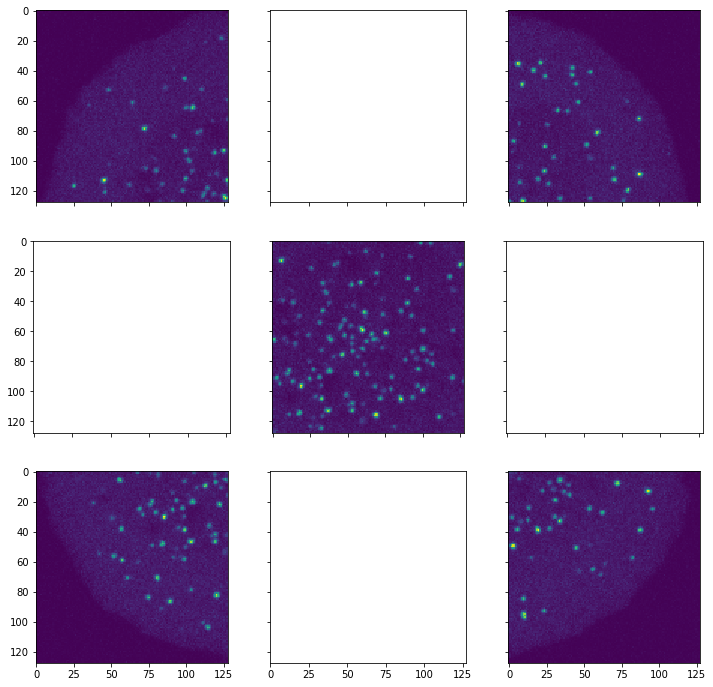

In [25]:
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, squeeze=False, figsize = [12,12])
ax = ax.flatten()
ax[0].imshow(np.asarray(list(tmp[0].getdata())).reshape(128,128))
ax[2].imshow(np.asarray(list(tmp[1].getdata())).reshape(128,128))
ax[4].imshow(np.asarray(list(tmp[4].getdata())).reshape(128,128))
ax[6].imshow(np.asarray(list(tmp[2].getdata())).reshape(128,128))
ax[8].imshow(np.asarray(list(tmp[3].getdata())).reshape(128,128))

In [155]:
img_ = Image.open(PATH+'s01_5m_2s_100ms_25p.tif')
nf = img_.n_frames #number of frames

img = []

width = 128
num_angles = 1
center = [230, 245]
rad = 130
edge_param = 0.7
r = rad-edge_param*width//2
crop_cent = []
for i in range(num_angles):
    crop_cent.append((np.int(center[0]+r*np.sin(2*np.pi*i/num_angles)), np.int(center[1]+r*np.cos(2*np.pi*i/num_angles))))
for t, l in crop_cent:
    base_img = []
    for i in range(nf):
        img_.seek(i)
        img.append(np.asarray(list(img_.getdata())).reshape(512,512)[t-width//2:t+width//2,l-width//2:l+width//2])
        base_img.append(img[-1])
    for t in range(2):
        for k in range(0,4):
            if t==0 and k==0: continue
            for i in range(len(base_img)):
                if t==0:
                    img.append(np.rot90(base_img[i],k=k))
                else:
                    img.append(np.rot90(base_img[i].T,k=k))

img = np.stack(img)
img = torch.from_numpy(np.ascontiguousarray(img)).float()
img = (img-img.min().item())/(img.max().item()-img.min().item())
img = img.view(nf*num_angles*8,1,width,width)
kernel_size = 8
img = nn.MaxPool2d(kernel_size)(img)
img = img.view(nf*num_angles*8,width**2//kernel_size**2)
img = img.cuda()

In [2]:
with open(PATH + 'img_data.pickle', 'rb') as f:
    img = pickle.load(f)

In [4]:
torch.zeros()

228884480

In [3]:
with open(PATH + 'frame_list.pickle', 'rb') as f:
    frame_list = pickle.load(f)

In [43]:
img_ = Image.open(PATH+'s01_5m_2s_100ms_25p.tif')
img_.seek(100)
img = torch.tensor(np.asarray(list(img_.getdata())).reshape(512,512)).view(1,1,512,512).float()

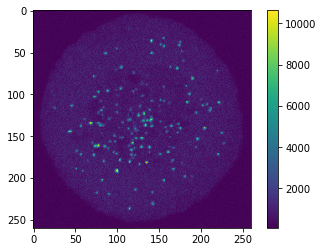

In [44]:
plt.imshow(torchvision.transforms.ToTensor()(img_.convert('F').crop((115,100,375,360)))[0])
plt.colorbar()

In [46]:
torchvision.transforms.ToTensor()(img_.convert('F').crop((115,100,375,360))).shape

torch.Size([1, 260, 260])

In [37]:
nn.Conv2d(1,16,3,stride=2)(img_.convert('F')).shape

TypeError: conv2d(): argument 'input' (position 1) must be Tensor, not Image

In [286]:
img = torch.from_numpy(np.ascontiguousarray(img)).float().cuda()

In [3]:
img = torch.randn(1,1,64)
convs = nn.Conv1d(1,16,2,stride=2)(img)
convs.shape

torch.Size([1, 16, 32])

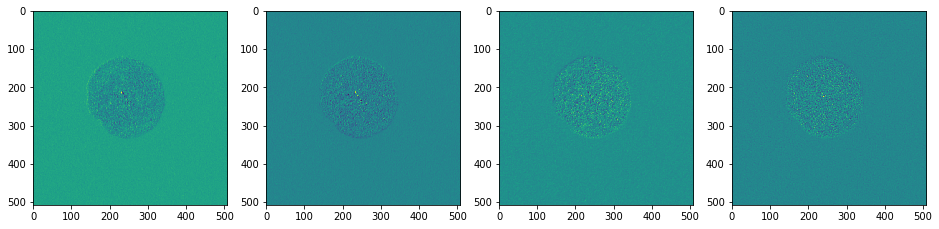

In [295]:
fig, ax = plt.subplots(1,4, figsize = [16,6])
for i in range(4):
    ax[i].imshow(convs[0,i,:,:].data.cpu())

In [296]:
convs.shape

torch.Size([1, 4, 508, 508])

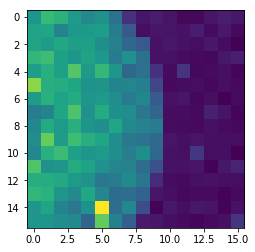

In [157]:
plt.imshow(img[0].view(16,16).data.cpu())

In [10]:
class PooledImageDataset(Dataset):
    def __init__(self, img, num_frames, num_angles, rnn_length=4):
        self.img = img
        self.nf = num_frames
        self.rnn_length = rnn_length
        self.frame_mod = rnn_length-1
        self.na = num_angles
        
    def __len__(self):
        return (self.nf-self.frame_mod)*self.na*8
    
    def __getitem__(self,idx):
        transform_number = idx//(self.nf-self.frame_mod)
        addon = self.frame_mod*transform_number
        return self.img[idx+addon:idx+addon+self.rnn_length]
        
        

In [63]:
class SubsetSampler(torch.utils.data.Sampler):
    r"""Samples elements from a given list of indices, without replacement.

    Arguments:
        indices (sequence): a sequence of indices
    """

    def __init__(self, indices, shuffle=False):
        self.indices = indices
        self.shuffle = shuffle

    def __iter__(self):
        if self.shuffle:
            return iter(np.random.permutation(self.indices))
        else:
            return iter(self.indices)

    def __len__(self):
        return len(self.indices)

In [50]:
ds = PooledImageDataset(img,nf,num_angles)
dl = torch.utils.data.DataLoader(ds,batch_size=2, sampler=SubsetSampler(np.random.permutation(range(len(ds)))[:4]))

In [128]:
255**3

16581375

In [27]:
ds = AllImageRNNDataset(img,frame_list,11)
dl = torch.utils.data.DataLoader(ds,batch_size=2, sampler=SubsetSampler(np.random.permutation(range(len(ds)))[:2]))

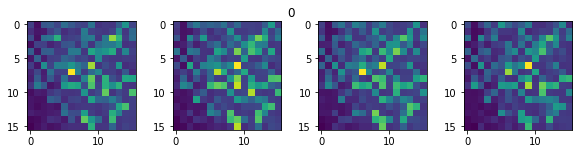

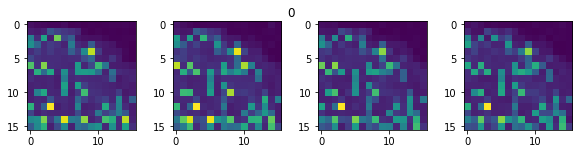

In [28]:
for i, data, in enumerate(dl):
    for k in range(data.shape[0]):
        fig, ax = plt.subplots(1,4, figsize=[10,2])
        for j in range(4):
            ax[j].imshow(data[k,j,:].view(16,16).data.cpu())
        plt.suptitle(f'{i}')
        plt.show()

In [56]:
class NFrameModel(nn.Module):
    def __init__(self, num_input_frames=3):
        super().__init__()
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fch1 = nn.Linear(num_input_frames*32, num_input_frames*32)
        self.fch2 = nn.Linear(num_input_frames*32, 32)
        self.fc3r = nn.Linear(32, 64)
        self.fc2r = nn.Linear(64, 128)
        self.fc1r = nn.Linear(128, 256)
        self.nf = num_input_frames
        
    def forward(self, img):
        codings = []
        for i in range(self.nf):
            if len(img.shape)==2:
                codings.append(F.relu(self.fc1(img[i].view(1,-1))))
            elif len(img.shape)==3:
                codings.append(F.relu(self.fc1(img[:,i,:])))
            codings[i] = F.relu(self.fc2(codings[i]))
            codings[i] = F.relu(self.fc3(codings[i]))
        h = torch.tanh(self.fch1(torch.cat(list(codings),dim=1).view(-1,self.nf*32)))
        h = torch.tanh(self.fch2(h))
        h = F.relu(self.fc3r(h))
        h = F.relu(self.fc2r(h))
        h = torch.clamp(self.fc1r(h),0,1)
        
        return h

In [10]:
ds = PooledImageDataset(img,nf,num_angles)
dl = torch.utils.data.DataLoader(ds,batch_size=500, shuffle=True)
model = NFrameModel().cuda()

It's the slice information that I need out of this. I need to make it so the dataloader takes care of that, or maybe the dataset?

In [49]:
def KFoldValidationConstructor(ds, K=5, rand_seed=42):
        full_ds_output = []
        for i in range(len(ds)):
            full_ds_output.append(ds[i].unsqueeze_(0))
        full_ds_output = torch.cat(full_ds_output)
        np.random.seed(rand_seed)
        lri = full_ds_output.shape[0]
        rand_idx = np.random.permutation(lri)
        
        datasets = []
        for k in range(K):
            if k==0:
                train_idx = rand_idx[:np.int(lri*(K-1)/K)]
                val_idx   = rand_idx[np.int(lri*(K-1)/K):]
            elif k==K-1:
                train_idx = rand_idx[np.int(lri*1/K):]
                val_idx   = rand_idx[:np.int(lri*1/K)]
            else:
                train_idx = np.concatenate((rand_idx[:np.int(lri*(K-1-k)/K)],rand_idx[np.int(lri*(K-k)/K)]),axis=None)
                val_idx   = rand_idx[np.int(lri*(K-1-k)/K):np.int(lri*(K-k)/K)]
            datasets.append((torch.utils.data.TensorDataset(full_ds_output[train_idx]),
                             torch.utils.data.TensorDataset(full_ds_output[val_idx])))        
        return datasets        

In [55]:
def RandomIndicesForKFoldValidation(ds_len, k, K=5, rand_seed=False):
    """
    k counts from zero up to K-1
    Todo:
        Consider how I handle the random seed and forcing the user to input one.
            I want to allow a random seed, but not require one.
        Consider handling k-counting better
    """
    if rand_seed: np.random.seed(rand_seed)
    rand_idx = np.random.permutation(ds_len)
    if k==0:
        train_idx = rand_idx[:np.int(ds_len*(K-1)/K)]
        val_idx   = rand_idx[np.int(ds_len*(K-1)/K):]
    elif k==K-1:
        train_idx = rand_idx[np.int(ds_len*1/K):]
        val_idx   = rand_idx[:np.int(ds_len*1/K)]
    else:
        train_idx = np.concatenate((rand_idx[:np.int(ds_len*(K-1-k)/K)],rand_idx[np.int(ds_len*(K-k)/K):]),axis=None)
        val_idx   = rand_idx[np.int(ds_len*(K-1-k)/K):np.int(ds_len*(K-k)/K)]    
    return (train_idx, val_idx)

In [3]:
rnn_length=3
ds = PooledImageDataset(img_array,nf,5)

bs = 7
train_dl = torch.utils.data.DataLoader(ds,batch_size=bs, sampler=SubsetSampler(train_idx, shuffle=True))
val_dl = torch.utils.data.DataLoader(ds,batch_size=2*bs, sampler=SubsetSampler(val_idx))
model = NFrameConvolutionalModel().cuda()
train_loss = []
val_loss = []
criterion = nn.MSELoss()

In [36]:
ds = AllImageRNNDataset(img,frame_list,11)
train_idx, val_idx = RandomIndicesForKFoldValidation(len(ds), 0, rand_seed=42, nORp=100000)
bs = 10000
train_dl = torch.utils.data.DataLoader(ds,batch_size=bs, sampler=SubsetSampler(train_idx, shuffle=True))
val_dl = torch.utils.data.DataLoader(ds,batch_size=2*bs, sampler=SubsetSampler(val_idx))
model = NFrameLinearModel()

rnn_length = model.nf

model.fc1.weight.data = torch.eye(256) + torch.randn(256,256)*1e-6
model.fc1.bias.data = torch.zeros(256) + torch.randn(256)*1e-6
model.fc2.weight.data = torch.eye(256) + torch.randn(256,256)*1e-6
model.fc2.bias.data = torch.zeros(256) + torch.randn(256)*1e-6
model.fc3.weight.data = torch.eye(256) + torch.randn(256,256)*1e-6
model.fc3.bias.data = torch.zeros(256) + torch.randn(256)*1e-6

model.fcr1.weight.data = torch.eye(256) + torch.randn(256,256)*1e-6
model.fcr1.bias.data = torch.zeros(256) + torch.randn(256)*1e-6
model.fcr2.weight.data = torch.eye(256) + torch.randn(256,256)*1e-6
model.fcr2.bias.data = torch.zeros(256) + torch.randn(256)*1e-6
model.fcr3.weight.data = torch.eye(256) + torch.randn(256,256)*1e-6
model.fcr3.bias.data = torch.zeros(256) + torch.randn(256)*1e-6

model.fch1.weight.data = torch.eye(rnn_length*256) + torch.randn(rnn_length*256,rnn_length*256)*1e-6
model.fch1.bias.data = torch.zeros(rnn_length*256) + torch.randn(rnn_length*256)*1e-6
model.fch2.weight.data = torch.eye(rnn_length*256) + torch.randn(rnn_length*256,rnn_length*256)*1e-6
model.fch2.bias.data = torch.zeros(rnn_length*256) + torch.randn(rnn_length*256)*1e-6
model.fch3.weight.data = torch.eye(rnn_length*256) + torch.randn(rnn_length*256,rnn_length*256)*1e-6
model.fch3.bias.data = torch.zeros(rnn_length*256) + torch.randn(rnn_length*256)*1e-6

model.fcu.weight.data = torch.cat(tuple(torch.eye(256) for _ in range(rnn_length)),dim=1)/rnn_length + torch.randn(256,256*rnn_length)*1e-6
model.fcu.bias.data = torch.zeros(256) + torch.randn(256)*1e-6

model = model.cuda()
opt = optim.Adam(model.parameters())
train_loss = []
val_loss = []
criterion = nn.MSELoss()

In [111]:
model.inter_relate

Sequential(
  (0): Dropout(p=0.5)
  (1): Linear(in_features=512, out_features=512, bias=True)
  (2): ReLU(inplace)
  (3): Dropout(p=0.5)
  (4): Linear(in_features=512, out_features=512, bias=True)
  (5): ReLU(inplace)
  (6): Dropout(p=0.5)
  (7): Linear(in_features=512, out_features=512, bias=True)
  (8): ReLU(inplace)
  (9): Dropout(p=0.5)
  (10): Linear(in_features=512, out_features=512, bias=True)
  (11): ReLU(inplace)
  (12): Dropout(p=0.5)
  (13): Linear(in_features=512, out_features=256, bias=True)
)

In [125]:
rnn_length = 10
ds = AllImageRNNDataset(img,frame_list,11,rnn_length+1)
train_idx, val_idx = RandomIndicesForKFoldValidation(len(ds), 0, rand_seed=42, nORp=1)
bs = 2000
train_dl = torch.utils.data.DataLoader(ds,batch_size=bs, sampler=SubsetSampler(train_idx, shuffle=True))
val_dl = torch.utils.data.DataLoader(ds,batch_size=2*bs, sampler=SubsetSampler(val_idx))
model = NFrameLinearModel(rnn_length)
for i in range(0,7,2):
    model.intra_relate[i].weight.data = torch.eye(256) + torch.randn(256,256)*1e-6
    model.intra_relate[i].bias.data = torch.zeros(256) + torch.randn(256)*1e-6
    model.inter_relate[i].weight.data = torch.eye(512) + torch.randn(512,512)*1e-6
    model.inter_relate[i].bias.data = torch.zeros(512) + torch.randn(512)*1e-6
model.inter_relate[8].weight.data = torch.cat((torch.eye(256),torch.eye(256)),dim=1)/2 + torch.randn(256,512)*1e-6
model.inter_relate[8].bias.data = torch.zeros(256) + torch.randn(256)*1e-6
model = model.cuda()
opt = optim.Adam(model.parameters())
train_loss = []
val_loss = []
criterion = nn.MSELoss()

In [123]:
ds = PooledImageDataset(img,nf,num_angles)
train_idx, val_idx = RandomIndicesForKFoldValidation(len(ds), 0, rand_seed=42)
bs = 500
train_dl = torch.utils.data.DataLoader(ds,batch_size=bs, sampler=SubsetSampler(train_idx, shuffle=True))
val_dl = torch.utils.data.DataLoader(ds,batch_size=2*bs, sampler=SubsetSampler(val_idx))
model = NFrameModel().cuda()

In [137]:
ds = AllImageFolderRNNDataset(IMAGES,frame_list)
train_idx, val_idx = RandomIndicesForKFoldValidation(len(ds), 0, rand_seed=42, nORp=5000)
bs = 500
train_dl = torch.utils.data.DataLoader(ds,batch_size=bs, sampler=SubsetSampler(train_idx, shuffle=True))
val_dl = torch.utils.data.DataLoader(ds,batch_size=2*bs, sampler=SubsetSampler(val_idx))
model = NFrameModel()
rnn_length = model.nf
model.fc1.weight.data = torch.eye(256) + torch.randn(256,256)*1e-6
model.fc1.bias.data = torch.zeros(256) + torch.randn(256)*1e-6
model.fc2.weight.data = torch.eye(256) + torch.randn(256,256)*1e-6
model.fc2.bias.data = torch.zeros(256) + torch.randn(256)*1e-6
model.fch.weight.data = torch.cat(tuple(torch.eye(256) for _ in range(rnn_length)),dim=1)/rnn_length + torch.randn(256,256*rnn_length)*1e-6
model.fch.bias.data = torch.zeros(256) + torch.randn(256)*1e-6
model = model.cuda()
opt = optim.Adam(model.parameters())
train_loss = []
val_loss = []
criterion = nn.MSELoss()

In [36]:
save_file = 'C:\\Users\\joshu\\Documents\\fastai\\courses\\kural_work\\train_and_val_loss.pickle'
with open(save_file,'wb') as f:
    pickle.dump((train_loss,val_loss),f)

In [15]:
from line_profiler import LineProfiler
def do_profile(follow=[]):
    def inner(func):
        def profiled_func(*args,**kwargs):
            try:
                profiler = LineProfiler()
                profiler.add_function(func)
                for f in follow:
                    profiler.add_module(f)
                profiler.enable_by_count()
                return func(*args,**kwargs)
            finally:
                profiler.print_stats()
        return profiled_func
    return inner

In [8]:
nn.ConvTranspose2d(10,1,3,stride=3)(nn.Conv2d(1,10,3,stride=3)(torch.rand((1,1,9,9)))).shape

torch.Size([1, 1, 9, 9])

In [11]:
%pdb

[autoreload of kural_core.models failed: Traceback (most recent call last):
  File "C:\Users\joshu\Miniconda3\envs\fastai\lib\site-packages\IPython\extensions\autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\joshu\Miniconda3\envs\fastai\lib\site-packages\IPython\extensions\autoreload.py", line 376, in superreload
    module = reload(module)
  File "C:\Users\joshu\Miniconda3\envs\fastai\lib\imp.py", line 315, in reload
    return importlib.reload(module)
  File "C:\Users\joshu\Miniconda3\envs\fastai\lib\importlib\__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 674, in exec_module
  File "<frozen importlib._bootstrap_external>", line 781, in get_code
  File "<frozen importlib._bootstrap_external>", line 741, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  Fil

Automatic pdb calling has been turned OFF


In [8]:
# @do_profile(follow=[AllImageRNNDataset,RandomIndicesForKFoldValidation,SubsetSampler,NFrameModel])
# def profile_fit():
restarts = 1
lr_start = 1e-3
lr_end = 1e-7
for restart in range(restarts):
    cycles = 5
    epochs = 5
    print(f'restart number {restart+1} out of {restarts}')
    opt = optim.SGD(model.parameters(), lr=lr_start, momentum=0)
    # lr_div = (lr_start/lr_end)**(1/epochs)
    time_list = []
    epoch_time_list = None
    cycle_print_str = 'Cycle: 0 ~ Remaining total: Unknown'
    print(cycle_print_str,end='')
    for cycle in range(cycles):
        ts = time.clock()
#         if cycle>0: epochs = epochs*2
        lr_start = lr_start*(0.999)**cycle
        epoch_print_str = f' ~ Epoch: 0 ~ Remaining in cycle: {(epochs*np.mean(epoch_time_list) if epoch_time_list is not None else 0):.3g}s'
        print(epoch_print_str, end='')
        epoch_time_list = []
        for epoch in range(epochs):
            ets = time.clock()
            opt.param_groups[0]['lr'] = lr_end + 0.5*(lr_start-lr_end)*(1+math.cos(cycle/cycles*np.pi))
    #         lr /= lr_div
            running_loss = 0.0
            model.train()
            for data in train_dl:
                data = data.float().cuda()
                data /= SCALE_FACTOR
                y_actual = data[:,rnn_length,:,:]
                opt.zero_grad()
                y_pred = model(data[:,0:rnn_length,:,:])
                loss = criterion(y_pred,y_actual)
                loss.backward()
                opt.step()
                running_loss += loss.item()
            train_loss.append(running_loss/len(train_dl))

            running_loss = 0.0
            model.eval()
            with torch.no_grad():
                for data in val_dl:
                    data = data.float().cuda()
                    data /= SCALE_FACTOR
                    y_actual = data[:,rnn_length,:,:]
                    y_pred = model(data[:,0:rnn_length,:,:])
                    running_loss += criterion(y_pred,y_actual).item()
            val_loss.append(running_loss/len(val_dl))
            epoch_time_list.append(time.clock()-ets)
            if epoch_print_str: 
                for _ in range(len(epoch_print_str)):
                    print('\b',end='')
            epoch_print_str = f' ~ Epoch: {epoch+1:2d}/{epochs} ~ Remaining in cycle: {(epochs-(epoch+1))*np.mean(epoch_time_list):.3g}s'
            print(epoch_print_str,end='')
        time_list.append(time.clock()-ts)
        if cycle_print_str: 
            for _ in range(len(cycle_print_str)+len(epoch_print_str)):
                print('\b',end='')
        remaining_time = (cycles-(cycle+1))*np.mean(time_list)
        cycle_print_str = f'Cycle: {cycle+1:3d}/{cycles} ~ Remaining total: {int(remaining_time//60)}m {remaining_time%60:02.0f}s'
        print(cycle_print_str,end='')
    for _ in range(len(cycle_print_str)):
                print('\b',end='')
    print(f'Spent {int(sum(time_list)//60)}m {sum(time_list)%60:2.0f}s doing {cycles*epochs} total steps for an average of {sum(time_list)/cycles/epochs:3.1f}s per step.')

# torch.save(model.state_dict(),'C:\\Users\\joshu\\Documents\\fastai\\courses\\kural_work\\big_linear_rnn_model.pth')

restart number 1 out of 1
Spent 4m 31s doing 25 total steps for an average of 10.8s per step.


In [5]:
torch.save(model.state_dict(),'C:\\Users\\joshu\\Documents\\fastai\\courses\\kural_work\\convolutional_rnn_model.pth')

In [10]:
nn.ConvTranspose2d(1,100,4,stride=2,padding=3)(nn.ReflectionPad2d(1)(torch.rand((1,1,16,16)))).shape

torch.Size([1, 100, 32, 32])

In [253]:
save_file = 'C:\\Users\\joshu\\Documents\\fastai\\courses\\kural_work\\train_and_val_loss.pickle'
with open(save_file,'rb') as f:
    train_loss, val_loss = pickle.load(f)

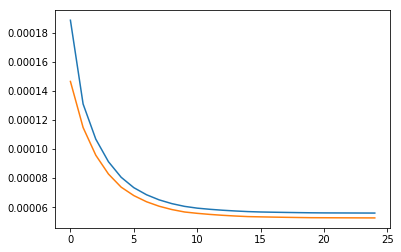

In [10]:
slc = slice(0,len(train_loss))
plt.plot(train_loss[slc])
plt.plot(val_loss[slc])

In [53]:
model.compress[1].__repr__()[:4] == 'Conv'

True

In [75]:
model.compress[6].bias.data.shape

torch.Size([32])

In [56]:
out_channel, in_channel, h, w = model.compress[6].weight.data.shape

In [58]:
if h%2==1:
    y = range(-(h-1)//2,(h+1)//2)
else:
    y = range(-h//2,h//2)
if w%2 == 1:
    x = range(-(w-1)//2,(w+1)//2)
else:
    y = range(-w//2,w//2)
X, Y = np.meshgrid(x,y)

In [59]:
X

array([[-3, -2, -1,  0,  1,  2,  3],
       [-3, -2, -1,  0,  1,  2,  3],
       [-3, -2, -1,  0,  1,  2,  3],
       [-3, -2, -1,  0,  1,  2,  3],
       [-3, -2, -1,  0,  1,  2,  3],
       [-3, -2, -1,  0,  1,  2,  3],
       [-3, -2, -1,  0,  1,  2,  3]])

In [60]:
Y

array([[-3, -3, -3, -3, -3, -3, -3],
       [-2, -2, -2, -2, -2, -2, -2],
       [-1, -1, -1, -1, -1, -1, -1],
       [ 0,  0,  0,  0,  0,  0,  0],
       [ 1,  1,  1,  1,  1,  1,  1],
       [ 2,  2,  2,  2,  2,  2,  2],
       [ 3,  3,  3,  3,  3,  3,  3]])

In [65]:
Z = np.exp(-(X**2+Y**2)/(2*(np.mean([h,w])/5)**2))

In [67]:
Z/np.sum(Z)

array([[0.00084, 0.00301, 0.00647, 0.00835, 0.00647, 0.00301, 0.00084],
       [0.00301, 0.01078, 0.02317, 0.0299 , 0.02317, 0.01078, 0.00301],
       [0.00647, 0.02317, 0.04981, 0.06428, 0.04981, 0.02317, 0.00647],
       [0.00835, 0.0299 , 0.06428, 0.08296, 0.06428, 0.0299 , 0.00835],
       [0.00647, 0.02317, 0.04981, 0.06428, 0.04981, 0.02317, 0.00647],
       [0.00301, 0.01078, 0.02317, 0.0299 , 0.02317, 0.01078, 0.00301],
       [0.00084, 0.00301, 0.00647, 0.00835, 0.00647, 0.00301, 0.00084]])

In [76]:
conv = nn.Conv2d(in_channels=2,out_channels=4,kernel_size=1,stride=1,padding=0)

In [4]:
def twoDgaussian(weight):
    h, w = weight.shape
    if h%2==1:
        y = range(-(h-1)//2,(h+1)//2)
    else:
        y = range(-h//2,h//2)
    if w%2 == 1:
        x = range(-(w-1)//2,(w+1)//2)
    else:
        x = range(-w//2,w//2)
    X, Y = np.meshgrid(x,y)
    Z = np.exp(-(X**2+Y**2)/(2*(np.mean([h,w])/5)**2))
    return Z/np.sum(Z)

In [5]:
for l in range(len(model.compress)):
    if model.compress[l].__repr__()[:4] == 'Conv':
        weight = model.compress[l].weight.data
        for o in range(weight.shape[0]):
            for i in range(weight.shape[1]):
                weight[o,i] = torch.tensor(twoDgaussian(weight[o,i])).float().cuda()/(weight.shape[1]*weight.shape[0])
            model.compress[l].bias.data[0] = 0

In [6]:
for l in range(len(model.decompress)):
    if model.decompress[l].__repr__()[:4] == 'Conv':
        weight = model.decompress[l].weight.data
        for o in range(weight.shape[0]):
            for i in range(weight.shape[1]):
                weight[o,i] = torch.tensor(twoDgaussian(weight[o,i])).float().cuda()/(weight.shape[1]*weight.shape[0])
            model.decompress[l].bias.data[0] = 0

In [117]:
model.evolve[1].bias.data.shape

torch.Size([1])

In [7]:
model.evolve[0].weight.data = torch.ones((1000,3,1,1),device=torch.device('cuda'))/3000
model.evolve[0].bias.data = torch.zeros(1000,device=torch.device('cuda'))
model.evolve[1].weight.data = torch.ones((1,1000,1,1),device=torch.device('cuda'))/1000
model.evolve[1].bias.data = torch.zeros(1,device=torch.device('cuda'))

In [74]:
tmpout.shape

torch.Size([1, 4, 2, 3])

In [78]:
tmpout

tensor([[[[ 2.8848,  3.2830,  3.6812],
          [ 4.0794,  4.4776,  4.8758]],

         [[-0.1608, -0.5434, -0.9260],
          [-1.3086, -1.6912, -2.0739]],

         [[ 3.6202,  3.8204,  4.0207],
          [ 4.2209,  4.4211,  4.6214]],

         [[-0.2216, -0.2914, -0.3611],
          [-0.4308, -0.5006, -0.5703]]]], grad_fn=<ThnnConv2DBackward>)

In [85]:
conv.weight

Parameter containing:
tensor([[[[ 0.0381]],

         [[ 0.3601]]],


        [[[-0.4994]],

         [[ 0.1168]]],


        [[[-0.4380]],

         [[ 0.6383]]],


        [[[-0.0859]],

         [[ 0.0162]]]], requires_grad=True)

In [79]:
conv.bias

Parameter containing:
tensor([ 0.3259, -0.4788, -0.4097, -0.2488], requires_grad=True)

In [86]:
tmp[0,0,:,:]*conv.weight[0,0,0,0] + tmp[0,1,:,:]*conv.weight[0,1,0,0] +conv.bias[0]

tensor([[2.8848, 3.2830, 3.6812],
        [4.0794, 4.4776, 4.8758]], grad_fn=<AddBackward0>)

In [132]:
model = NFrameLinearModel().cuda()

model.load_state_dict(torch.load('C:\\Users\\joshu\\Documents\\fastai\\courses\\kural_work\\big_linear_rnn_model.pth'))

In [283]:
m = nn.Conv1d(16, 33, 3, stride=2)
input = torch.randn(20, 16, 50)
output = m(input)

In [284]:
output.shape

torch.Size([20, 33, 24])

In [384]:
%pdb

Automatic pdb calling has been turned OFF


In [29]:
%pdb

Automatic pdb calling has been turned ON


In [142]:
tmp = nn.InstanceNorm2d(4)

In [148]:
tmp.

In [146]:
model.compress[2].bias

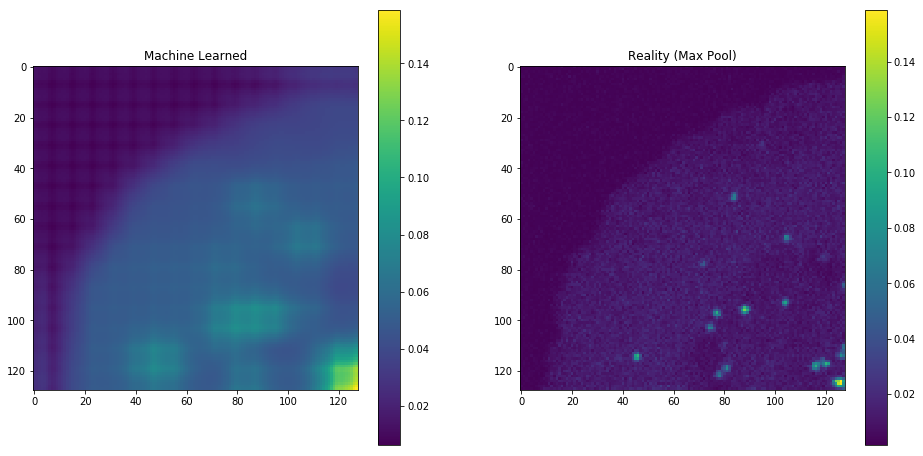

In [13]:
which_idx = train_idx
idx = np.random.choice(range(len(which_idx)))
# x = ds[val_idx[idx]].cuda()[None,:,:]
x = ds[which_idx[idx]]
x = torch.tensor(x).float().cuda()/SCALE_FACTOR
# x = nn.MaxPool2d(8)(x).view(-1,256)
model.eval()
y_actual = x[rnn_length,:,:].cpu().data.numpy()
y_pred = model(x[0:rnn_length].view(1,3,128,128)).cpu().data[0].numpy()
y_pred -= (np.min(y_pred)-np.min(y_actual))
y_pred /= (np.max(y_pred)/np.max(y_actual))
fig, ax = plt.subplots(1,2,figsize=(16,8))
im0 = ax[0].imshow(y_pred)
ax[0].set_title('Machine Learned')
im1 = ax[1].imshow(y_actual)
ax[1].set_title('Reality (Max Pool)')
plt.colorbar(mappable=im0,ax=ax[0])
plt.colorbar(mappable=im1,ax=ax[1])
# lss = criterion(y_pred,x[0,rnn_length,:])
# plt.suptitle(f'loss = {lss}')
plt.show()

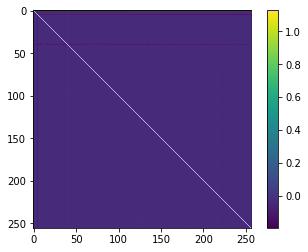

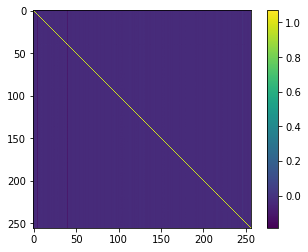

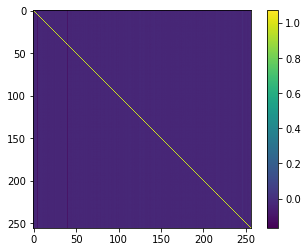

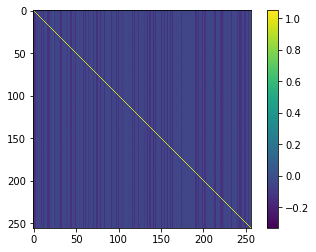

In [90]:
plt.figure()
for i in range(len(model.intra_relate)):
    if i%2==1: continue
    plt.imshow(model.intra_relate[i].weight.data.cpu() + model.intra_relate[i].bias.data.cpu())
    plt.colorbar()
    plt.show()

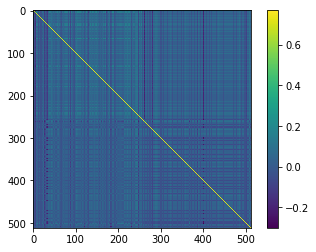

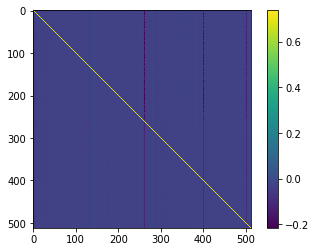

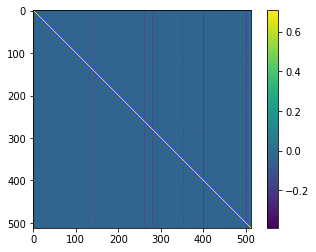

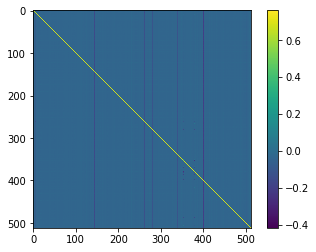

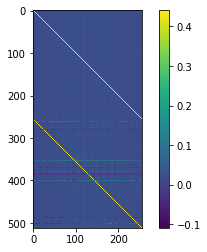

In [101]:
plt.figure()
for i in range(len(model.inter_relate)):
    if i%2==1: continue
    plt.imshow(np.log(torch.transpose(model.inter_relate[i].weight.data.cpu(),0,1) + model.inter_relate[i].bias.data.cpu()+1))
    plt.colorbar()
    plt.show()

In [133]:
idx = np.random.choice(range(len(val_idx)))
x = ds[val_idx[idx]].cuda()[None,:,:]
input = x[0,0]
input.shape

torch.Size([256])

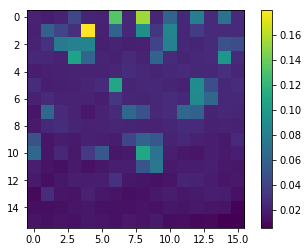

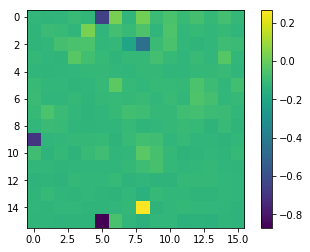

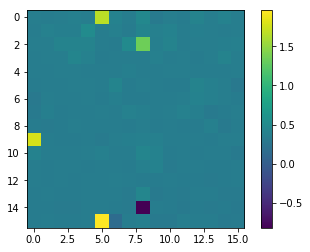

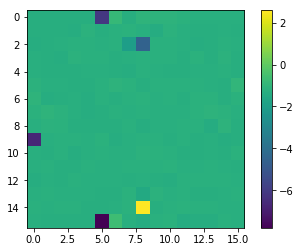

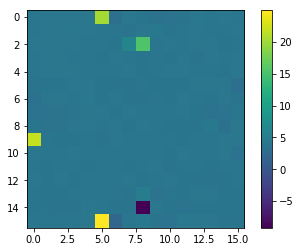

In [134]:
for i in range(len(model.intra_relate)):
    if i%2==1:continue
    plt.imshow(input.view(16,16).data.cpu())
    plt.colorbar()
    plt.show()
    input = input@torch.transpose(model.intra_relate[0].weight.data,0,1)+model.intra_relate[0].bias.data
plt.imshow(input.view(16,16).data.cpu())
plt.colorbar()
plt.show()

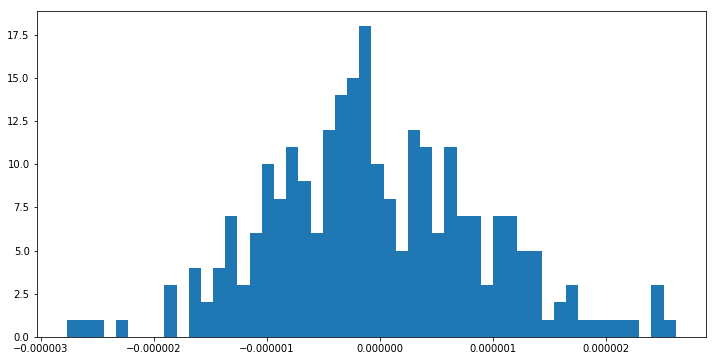

In [131]:
plt.figure(figsize=[12,6])
plt.hist(model.intra_relate[0].weight.data[0,1:].cpu(),bins=50)
plt.show()

In [ ]:
bad_list = []
ts = time.clock()
for i in range(1,len(ds)+1):
    if i%10000 == 9999:
        print(i, time.clock()-ts)
        ts = time.clock()
    try:
        if ds[i].shape[0] != 4:
            print(i, ds[i].shape[0], 'Bad RNN')
        if ds[i].shape[1] != 128 or ds[i].shape[2] != 128:
            print(i, ds[i].shape[1:3], 'Bad Crop')
    except:
        bad_list.append(i)
        continue
    

9999 5.934044932967534
19999 7.054163624812941
29999 5.791748477153574
39999 15.709974287447132
49999 26.153863309105823
59999 55.812111991870815


In [ ]:
plt.plot

In [102]:
train_idx[idx]

807402

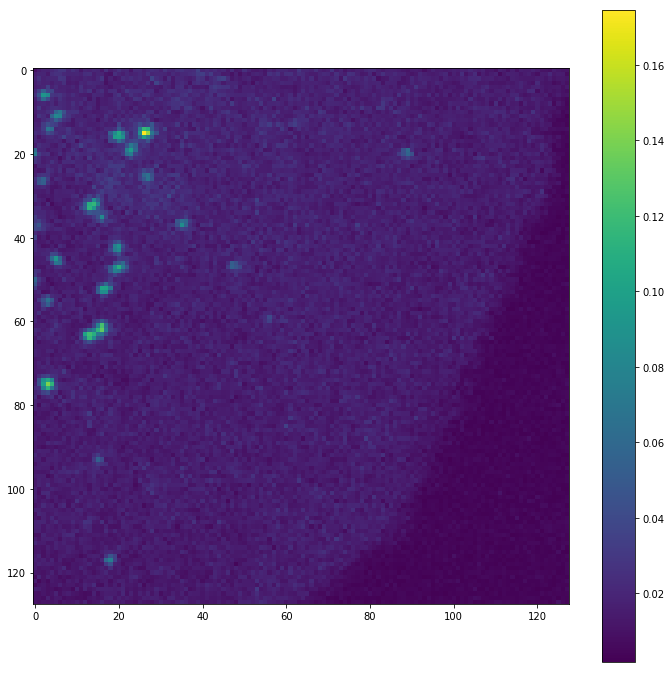

In [61]:
img_ = Image.open(IMAGES+f'{mn:08d}.tif')
for _ in range(4):
    img_ = img_.rotate(90)
img = torchvision.transforms.ToTensor()(img_)[0].float()
plt.figure(figsize=[12,12])
plt.imshow(img/SCALE_FACTOR)
plt.colorbar()

In [414]:
criterion(x[rnn_length],y_pred)

tensor(3.2202e-05, device='cuda:0', grad_fn=<MeanBackward1>)

In [352]:
x.shape

torch.Size([4, 256])

In [63]:
len(x[0:rnn_length].shape)

2

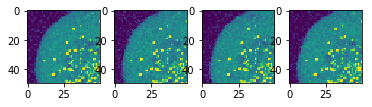

In [4]:
imgs = img
steps = 4
sz = 50
out_img = imageTransformer(img,steps,sz)
fig,ax = plt.subplots(1,4)
for i in range(4):
    ax[i].imshow(out_img[i])
plt.show()

(array([647374.,  81471.,  20938.,  91392., 341101., 191957.,  20760.,  10952.,   9103.,  14952.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

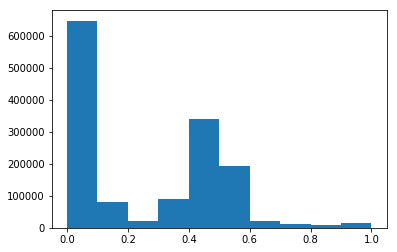

In [9]:
plt.hist(img.flatten())

In [35]:
set_lrs(opt, 1e-4)

In [36]:
fit(m, md, 5, opt, F.mse_loss)

epoch      trn_loss   val_loss                                                                                         
    0      0.001518   0.002532  
    1      0.00139    0.002379                                                                                         
    2      0.001307   0.002297                                                                                         
    3      0.001248   0.002216                                                                                         
    4      0.001187   0.002115                                                                                         



[0.0021145243663340807]

In [14]:
set_lrs(opt, 1e-5)
fit(m, md, 5, opt, F.mse_loss)

NameError: name 'opt' is not defined

In [73]:
mse = []
new_y = []
old_y = []
new_x = []
for i in range(47):
    p = m(*V(T(np.stack([x1[[i],:],x2[[i],:],x3[[i],:]],axis=0))))
    new_y.append(to_np(p).reshape(128,128))
    old_y.append(y[i,:].reshape(128,128))
    new_x.append(x1[i,:].reshape(128,128))
    if i>0:
        mse.append(np.sum(np.abs(new_y[-1].flatten()-old_y[-1].flatten()))/new_y[-1].size)

In [32]:
new_y = []
old_y = []
start = 140
for i in range(30):
    x1 = img[4*i,start:start+32,start:start+32].flatten()
    x2 = img[4*i+1,start:start+32,start:start+32].flatten()
    x3 = img[4*i+2,start:start+32,start:start+32].flatten()
    y = img[4*i+3,start:start+32,start:start+32].flatten()
    p = m(*V(T(np.stack([x1,x2,x3],axis=0))))
    new_y.append(to_np(p).reshape(32,32))
    old_y.append(y.reshape(32,32))

In [9]:
new_y = []
old_y = []
width=100
for i in range(30):
    old_y_columns = []
    new_y_columns = []
    for c in range(0,width,sz):
        old_y_rows = []
        new_y_rows = []
        for r in range(0,width,sz):
            old_x1 = img[4*i,c:c+sz,r:r+sz].flatten()
            old_x2 = img[4*i+1,c:c+sz,r:r+sz].flatten()
            old_x3 = img[4*i+2,c:c+sz,r:r+sz].flatten()
            old_y_rows.append(img[4*i+3,c:c+sz,r:r+sz])
            p = m(*V(T(np.stack([old_x1,old_x2,old_x3],axis=0))))
            new_y_rows.append(to_np(p).reshape(sz,sz))
        old_y_columns.append(np.c_[tuple(old_y_rows)])
        new_y_columns.append(np.c_[tuple(new_y_rows)])
    new_y.append(np.r_[tuple(new_y_columns)])
    old_y.append(np.r_[tuple(old_y_columns)])

In [19]:
old_x1

array([], dtype=float64)

In [22]:
for i in range(0,100,50):
    print(i)

0
50


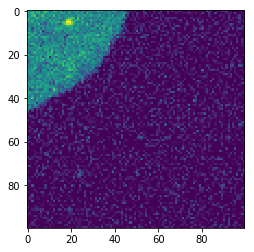

In [18]:
plt.imshow(img[4,200:400,200:400])

In [77]:
new_y[0].shape

(512, 512)

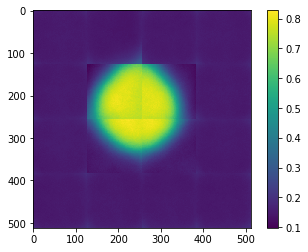

In [17]:
plt.imshow(new_y[0])
plt.colorbar()
plt.show()

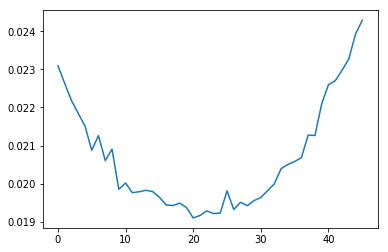

In [75]:
plt.plot(mse)

In [57]:
??F.l1_loss

In [ ]:
for i in range(47):
    plt.imshow(new_y[i])

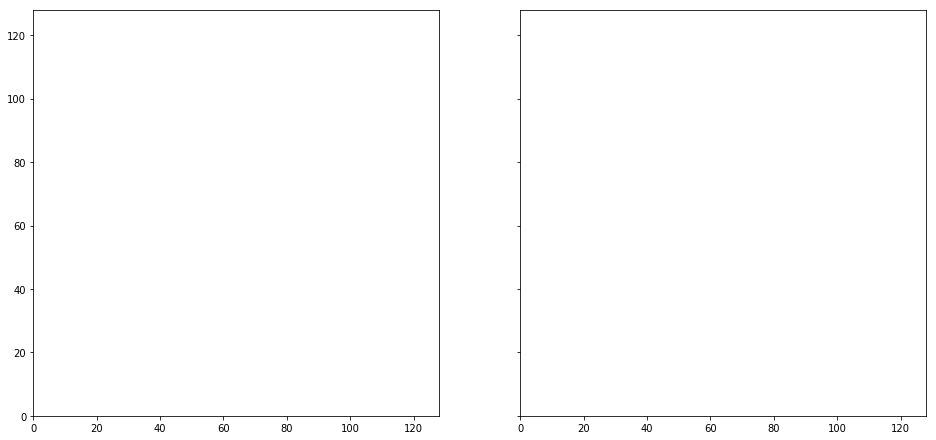

In [76]:
fig,ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=[16,8])
ax[0].set_xlim(( 0, 128))
ax[0].set_ylim((0, 128))
ax[1].set_xlim(( 0, 128))
ax[1].set_ylim((0, 128))

im0 = ax[0].imshow(new_y[0], animated=True)
im1 = ax[1].imshow(old_y[0], animated=True)
im = (im0,im1)

def init():
    im[0].set_array([[]])
    im[1].set_array([[]])
    return im,

def animate(i,y0,y1):
    im[0].set_array(y0[i])
    im[1].set_array(y1[i])
    return  im,

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=47, fargs=(new_y,old_y), interval=200, blit=False)
HTML(anim.to_html5_video())

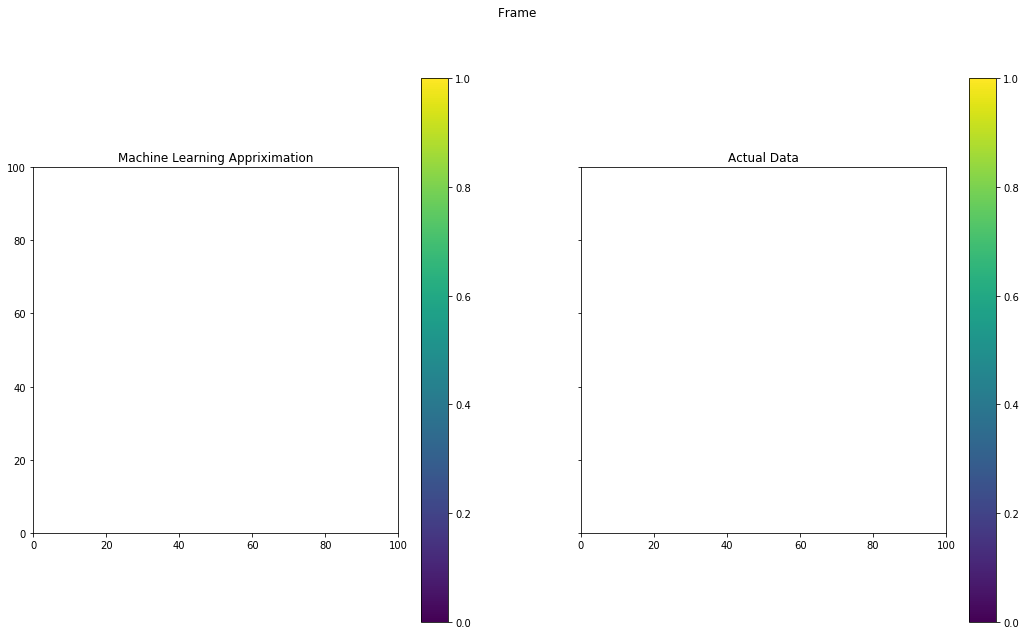

In [10]:
fig,ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=[18,10])
ax[0].set_xlim(( 0, width))
ax[0].set_ylim((0, width))
ax[1].set_xlim(( 0, width))
ax[1].set_ylim((0, width))
ax[0].set_title('Machine Learning Appriximation')
ax[1].set_title('Actual Data')
im0 = ax[0].imshow(new_y[0], animated=True)
im1 = ax[1].imshow(old_y[0], animated=True)
im0.set_clim(0,1)
im1.set_clim(0,1)
plt.colorbar(mappable=im0,ax=ax[0])
plt.colorbar(mappable=im1,ax=ax[1])
im = (im0,im1)

def init():
    im[0].set_array([[]])
    im[1].set_array([[]])
    plt.suptitle(f'Frame ')
    return im,

def animate(i,y0,y1):
    im[0].set_array(y0[i])
    im[1].set_array(y1[i])
    plt.suptitle(f'Frame {i}')
    im[0].set_clim(0,1)
    im[1].set_clim(0,1)
    return  im,

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=30, fargs=(new_y,old_y), interval=200, blit=False)
HTML(anim.to_html5_video())

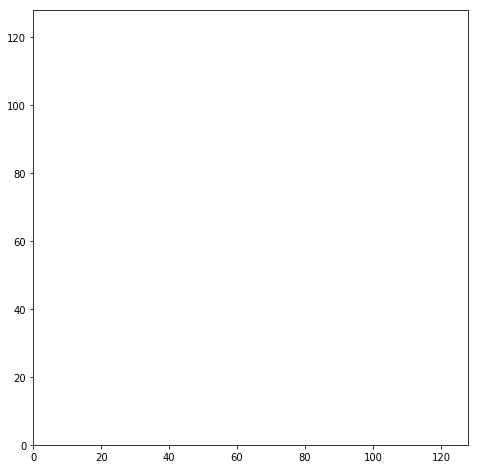

In [54]:
fig,ax = plt.subplots(figsize=[8,8])
ax.set_xlim(( 0, 128))
ax.set_ylim((0, 128))

im0 = ax.imshow(new_x[0], animated=True)

def init():
    im0.set_array([[]])
    return im,

def animate(i,y0):
    im0.set_array(y0[i])
    return  im,

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=47, fargs=[new_x], interval=20, blit=False)
HTML(anim.to_html5_video())

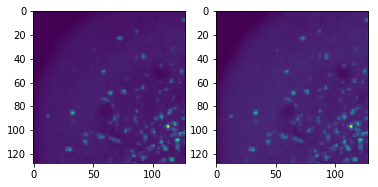

In [82]:
fig, ax = plt.subplots(nrows=1,ncols=2)
ax[0].imshow(new_y[0])
ax[1].imshow(np.stack(old_y).mean(axis=0))
plt.show()

In [81]:
np.stack(old_y).mean(axis=0).shape

(128, 128)

In [75]:
tmp = (np.stack([[1,2,3],[4,5,6],[7,8,9]]),np.stack([[1,2,3],[4,5,6],[7,8,9]]))
tmpl = [np.r_[tmp] for _ in range(3)]
np.c_[tuple(tmpl)]

array([[1, 2, 3, 1, 2, 3, 1, 2, 3],
       [4, 5, 6, 4, 5, 6, 4, 5, 6],
       [7, 8, 9, 7, 8, 9, 7, 8, 9],
       [1, 2, 3, 1, 2, 3, 1, 2, 3],
       [4, 5, 6, 4, 5, 6, 4, 5, 6],
       [7, 8, 9, 7, 8, 9, 7, 8, 9]])

In [63]:
np.stack(tmpl).shape

(3, 2, 3, 3)

In [304]:
tmp = ds[98239][0,:]

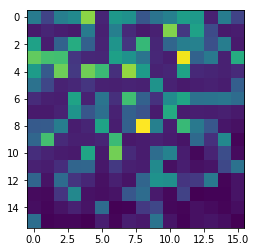

In [306]:
plt.imshow(tmp.view(16,16))

In [355]:
class eyeModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.eye = nn.Linear(512,256)
    
    def forward(self,img):
        return self.eye(img)

In [356]:
m = eyeModel().cuda()

In [360]:
m.eye.weight.data.shape

torch.Size([256, 512])

In [329]:
m.eye.weight.data = torch.cat((torch.eye(256),torch.eye(256)))
m.eye.bias.data = torch.zeros_like(m.eye.bias.data)

In [330]:
m.eye.bias.shape

torch.Size([256])

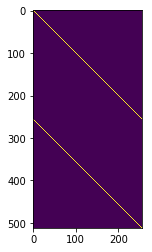

In [326]:
plt.imshow(m.eye.weight.data)

In [322]:
import torch
fold = nn.Fold(output_size=(4, 5), kernel_size=(2, 2))
input = torch.randn(1, 3 * 2 * 2, 12)
output = fold(input)
output.size()

torch.Size([1, 3, 4, 5])